# TLS Testing

In [1]:
!pip install transitleastsquares

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 1.3 MB/s 
     |████████████████████████████████| 394 kB 8.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.5 MB 51.0 MB/s 
     |████████████████████████████████| 832 kB 49.6 MB/s 
     |████████████████████████████████| 48 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 40.7 MB/s 
  Created wheel for batman-package: filename=batman_package-2.4.9-cp37-cp37m-linux_x86_64.whl size=221115 sha256=14cf7eaaa6f4ab745f01297a3878dc830baa8d452752c9638c352eae4cbf3370
  Stored in directory: /root/.cache/pip/wheels/90/76/e2/1e2923a7fe1c1ee8d6f5ae53e8f1bc75e070f5f174bf02badc
Successfully built batman-package


In [75]:
from transitleastsquares import transitleastsquares
import pandas as pd
lc = pd.read_csv('/content/TIC_5714469.csv')
lc = lc.dropna(subset=['detrended_flux','cleaned_time'])
time = lc['cleaned_time']
flux = lc['detrended_flux']

tls_model = transitleastsquares(time,flux)

In [76]:
results = tls_model.power()

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 37 durations
Searching 13376 data points, 2063 periods from 0.602 to 11.65 days
Using all 2 CPU threads


100%|██████████| 2063/2063 periods | 00:48<00:00


Searching for best T0 for period 0.86264 days


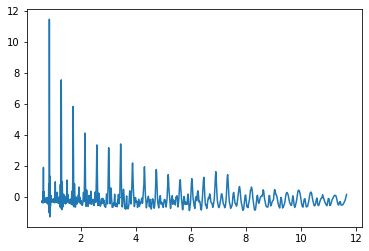

In [77]:
import numpy as np
import matplotlib.pyplot as plt
greatest_power = np.argmax(results.power)
plt.plot(results.periods,results.power)

# Actual Method + Tests

In [140]:
def run_tls(time, flux, 
            tls_params: dict = {'min_per':0.5, 'max_per':15, 
                                'minimum_n_transit':2, 
                                'freq_factor':1,
                                'durations':[0.05, 0.06666666666666668, 
                                             0.08333333333333334, 0.1,
                                             0.11666666666666668, 
                                             0.13333333333333336,
                                             0.15000000000000002, 
                                             0.16666666666666669, 
                                             0.18333333333333335, 0.2], 
                                'objective':'snr'}): 

    '''
    args: 
        stitched_lc: list of stitched light curve arrays [time, flux]
        tls_params: params for tls execution. 
    returns: 
        best_params: [index, period, t0, duration, sig_diff] for highest power period (sig_diff is sig_diff between left/right depths)
        results: the TLS results array 
        tls_model: the BTS model  
        in_transit_mask: mask for the in_transit points. to get not in transit, do ~in_transit_mask
    '''

    import numpy as np
    from transitleastsquares import transitleastsquares
    from transitleastsquares import transit_mask
    from transitleastsquares.stats import intransit_stats

    durations = np.array(tls_params['durations'])
    tls_model = transitleastsquares(time, flux)
    results = tls_model.power(period_min=tls_params['min_per'],period_max=tls_params['max_per'],objective=tls_params['objective'])
    '''
    results = tls_model.autopower(durations, frequency_factor=bls_params['freq_factor'], 
                            minimum_period=bls_params['min_per'], 
                            maximum_period=bls_params['max_per'],
                            objective=bls_params['objective'])
                            '''

    index = np.argmax(results.power)
    period = results.periods[index]
    t0 = results.T0 # what is t0?
    duration = results.duration
    in_transit = transit_mask(time, period, 2*duration, t0) #what is this for?

    best_params = [index, period, t0, duration]
    

    return best_params, results, tls_model, in_transit 

In [141]:
best_params,results,tls_model,in_transit = run_tls(time,flux)

/usr/local/lib/python3.7/dist-packages/transitleastsquares/validate.py:57: UserWarning: Ignoring unknown parameter: objective
  warnings.warn(text)


Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 37 durations
Searching 13376 data points, 2063 periods from 0.602 to 11.65 days
Using all 2 CPU threads


100%|██████████| 2063/2063 periods | 00:42<00:00


Searching for best T0 for period 0.86264 days


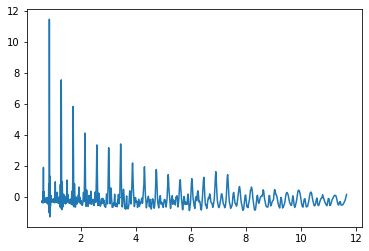

In [128]:
plt.plot(results.periods,results.power)

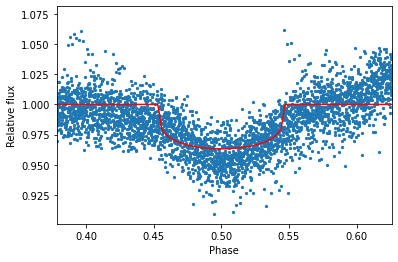

In [112]:
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model,'r')
plt.scatter(results.folded_phase, results.folded_y, s=5)
transit_index = np.where(results.model_folded_model<np.mean(results.model_folded_model))[0]
plt.xlim(results.folded_phase[transit_index-1000][0],results.folded_phase[transit_index+1000][-1])
plt.xlabel('Phase')
plt.ylabel('Relative flux');

# BLS Comparision

In [67]:
def run_bls(time, flux, 
            bls_params: dict = {'min_per':0.5, 'max_per':15, 
                                'minimum_n_transit':2, 
                                'freq_factor':1,
                                'durations':[0.05, 0.06666666666666668, 
                                             0.08333333333333334, 0.1,
                                             0.11666666666666668, 
                                             0.13333333333333336,
                                             0.15000000000000002, 
                                             0.16666666666666669, 
                                             0.18333333333333335, 0.2], 
                                'objective':'snr'}, 
            compute_stats: bool = True): 

    '''
    args: 
        stitched_lc: list of stitched light curve arrays [time, flux]
        bls_params: params for bls execution. see documentation
        compute_stats: compute statistics on best period/duration combination? default False
    returns: 
        best_params: [index, period, t0, duration, sig_diff] for highest power period (sig_diff is sig_diff between left/right depths)
        results: the BLS results array 
        bls_model: the BLS model  
        in_transit_mask: mask for the in_transit points. to get not in transit, do ~in_transit_mask
        stats: if compute_stats==True, then the stats on the best period/duration/t0 are returned
    '''

    from astropy.timeseries import BoxLeastSquares
    import numpy as np

    durations = np.array(bls_params['durations'])
    bls_model = BoxLeastSquares(t=time, y=flux)
    results = bls_model.autopower(durations, frequency_factor=bls_params['freq_factor'], 
                            minimum_period=bls_params['min_per'], 
                            maximum_period=bls_params['max_per'],
                            objective=bls_params['objective'])

    index = np.argmax(results.power)
    period = results.period[index]
    t0 = results.transit_time[index]
    duration = results.duration[index]
    in_transit = bls_model.transit_mask(time, period, 2*duration, t0)

    best_params = [index, period, t0, duration]

    if compute_stats: 
        stats = bls_model.compute_stats(period, duration, t0)

        depth_odd = stats['depth_odd']
        err_odd = depth_odd[1]
        depth_odd = depth_odd[0]
        depth_even = stats['depth_even']
        err_even = depth_even[1]
        depth_even = depth_even[0]

        diff = np.abs(depth_odd-depth_even)
        unc_diff = ((err_even/depth_even)**2+(err_odd/depth_odd)**2)**0.5
        sig_diff = diff/unc_diff 

        best_params.append(sig_diff)

        return best_params, results, bls_model, in_transit, stats

    else: 
        return best_params, results, bls_model, in_transit 

In [115]:
best_params,bls_results,bls_model,in_transit,stats = run_bls(time,flux)

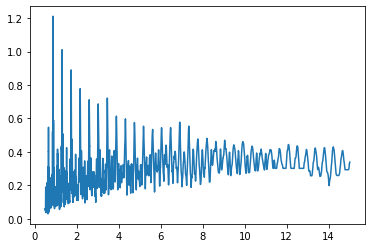

In [116]:
plt.plot(bls_results.period,bls_results.power)